# Object Detection with KerasCV

**Author:** [lukewood](https://twitter.com/luke_wood_ml)<br>
**Date created:** 2023/04/08<br>
**Last modified:** 2023/08/10<br>
**Description:** Train an object detection model with KerasCV.

KerasCV offers a complete set of production grade APIs to solve object detection
problems.
These APIs include object-detection-specific
data augmentation techniques, Keras native COCO metrics, bounding box format
conversion utilities, visualization tools, pretrained object detection models,
and everything you need to train your own state of the art object detection
models!

Let's give KerasCV's object detection API a spin.

In [1]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 16.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

## Object detection introduction

Object detection is the process of identifying, classifying,
and localizing objects within a given image.  Typically, your inputs are
images, and your labels are bounding boxes with optional class
labels.
Object detection can be thought of as an extension of classification, however
instead of one class label for the image, you must detect and localize an
arbitrary number of classes.

**For example:**

<img width="300" src="https://i.imgur.com/8xSEbQD.png">

The data for the above image may look something like this:
```python
image = [height, width, 3]
bounding_boxes = {
  "classes": [0], # 0 is an arbitrary class ID representing "cat"
  "boxes": [[0.25, 0.4, .15, .1]]
   # bounding box is in "rel_xywh" format
   # so 0.25 represents the start of the bounding box 25% of
   # the way across the image.
   # The .15 represents that the width is 15% of the image width.
}
```

Since the inception of [*You Only Look Once*](https://arxiv.org/abs/1506.02640)
(aka YOLO),
object detection has primarily been solved using deep learning.
Most deep learning architectures do this by cleverly framing the object detection
problem as a combination of many small classification problems and
many regression problems.

More specifically, this is done by generating many anchor boxes of varying
shapes and sizes across the input images and assigning them each a class label,
as well as `x`, `y`, `width` and `height` offsets.
The model is trained to predict the class labels of each box, as well as the
`x`, `y`, `width`, and `height` offsets of each box that is predicted to be an
object.

**Visualization of some sample anchor boxes**:

<img width="400" src="https://i.imgur.com/cJIuiK9.jpg">

Objection detection is a technically complex problem but luckily we offer a
bulletproof approach to getting great results.
Let's do this!

## Perform detections with a pretrained model

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

The highest level API in the KerasCV Object Detection API is the `keras_cv.models` API.
This API includes fully pretrained object detection models, such as
`keras_cv.models.RetinaNet`.

Let's get started by constructing a RetinaNet pretrained on the `pascalvoc`
dataset.

In [4]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

142662880/142662880 [==============================] - 7s 0us/step


Notice the `bounding_box_format` argument?

Recall in the section above, the format of bounding boxes:

```
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

This argument describes *exactly* what format the values in the `"boxes"`
field of the label dictionary take in your pipeline.
For example, a box in `xywh` format with its top left corner at the coordinates
(100, 100) with a width of 55 and a height of 70 would be represented by:
```
[100, 100, 55, 75]
```

or equivalently in `xyxy` format:

```
[100, 100, 155, 175]
```

While this may seem simple, it is a critical piece of the KerasCV object
detection API!
Every component that processes bounding boxes requires a
`bounding_box_format` argument.
You can read more about
KerasCV bounding box formats [in the API docs](https://keras.io/api/keras_cv/bounding_box/formats/).


This is done because there is no one correct format for bounding boxes!
Components in different pipelines expect different formats, and so by requiring
them to be specified we ensure that our components remain readable, reusable,
and clear.
Box format conversion bugs are perhaps the most common bug surface in object
detection pipelines - by requiring this parameter we mitigate against these
bugs (especially when combining code from many sources).

Next let's load an image:

1215963/1215963 [==============================] - 1s 1us/step


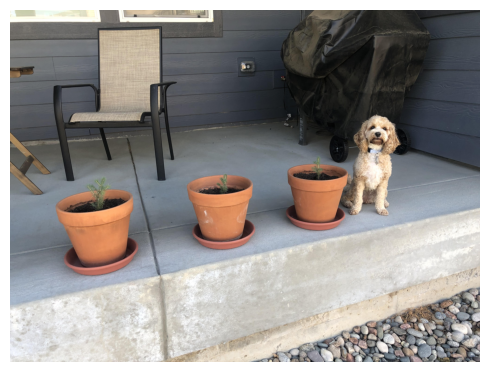

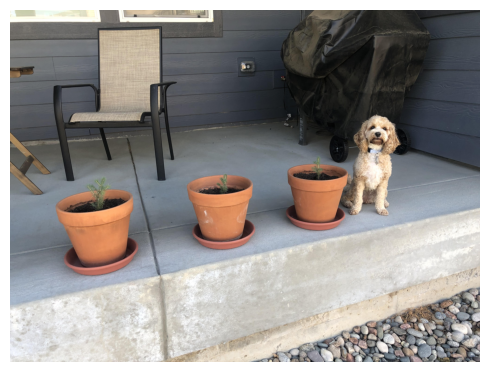

In [5]:
filepath = tf.keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

To use the `RetinaNet` architecture with a ResNet50 backbone, you'll need to
resize your image to a size that is divisible by 64.  This is to ensure
compatibility with the number of downscaling operations done by the convolution
layers in the ResNet.

If the resize operation distorts
the input's aspect ratio, the model will perform signficantly poorer.  For the
pretrained `"retinanet_resnet50_pascalvoc"` preset we are using, the final
`MeanAveragePrecision` on the `pascalvoc/2012` evaluation set drops to `0.15`
from `0.38` when using a naive resizing operation.

Additionally, if you crop to preserve the aspect ratio as you do in classification
your model may entirely miss some bounding boxes.  As such, when running inference
on an object detection model we recommend the use of padding to the desired size,
while resizing the longest size to match the aspect ratio.

KerasCV makes resizing properly easy; simply pass `pad_to_aspect_ratio=True` to
a `keras_cv.layers.Resizing` layer.

This can be implemented in one line of code:

In [6]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

This can be used as our inference preprocessing pipeline:

In [7]:
image_batch = inference_resizing([image])

`keras_cv.visualization.plot_bounding_box_gallery()` supports a `class_mapping`
parameter to highlight what class each box was assigned to.  Let's assemble a
class mapping now.

In [8]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Just like any other `keras.Model` you can predict bounding boxes using the
`model.predict()` API.

1/1 [==============================] - 16s 16s/step


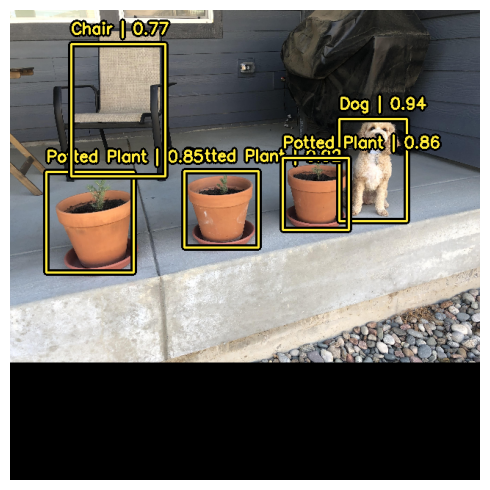

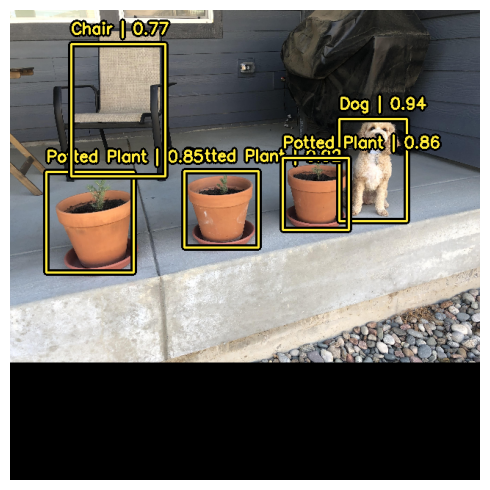

In [9]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In order to support this easy and intuitive inference workflow, KerasCV
performs non-max suppression inside of the `RetinaNet` class.
Non-max suppression is a traditional computing algorithm that solves the problem
of a model detecting multiple boxes for the same object.

Non-max suppression is a highly configurable algorithm, and in most cases you
will want to customize the settings of your model's non-max
suppression operation.
This can be done by overriding to the `model.prediction_decoder` attribute.

To show this concept off, let's temporarily disable non-max suppression on our
RetinaNet.  This can be done by writing to the `prediction_decoder` attribute.

1/1 [==============================] - 2s 2s/step


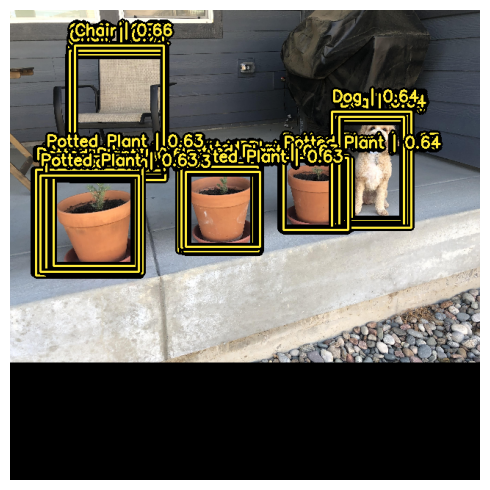

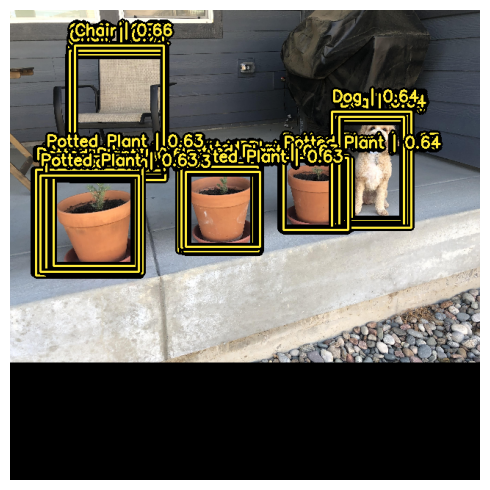

In [10]:
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model.prediction_decoder = prediction_decoder

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)


Next, let's re-configure `keras_cv.layers.MultiClassNonMaxSuppression` for our
use case!
In this case, we will tune the `iou_threshold` to `0.2`, and the
`confidence_threshold` to `0.7`.

Raising the `confidence_threshold` will cause the model to only output boxes
that have a higher confidence score. `iou_threshold` controls the threshold of
intersection over union (IoU) that two boxes must have in order for one to be
pruned out.
[More information on these parameters may be found in the TensorFlow API docs](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

1/1 [==============================] - 2s 2s/step


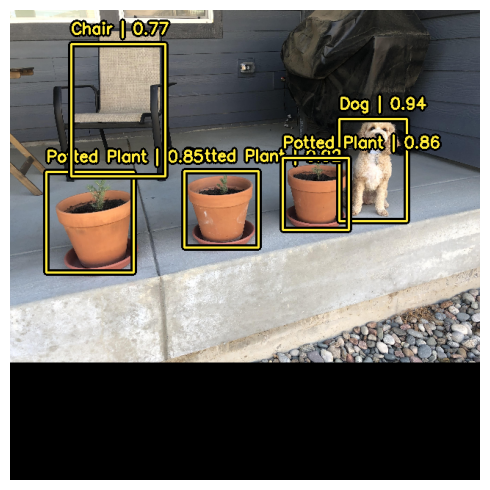

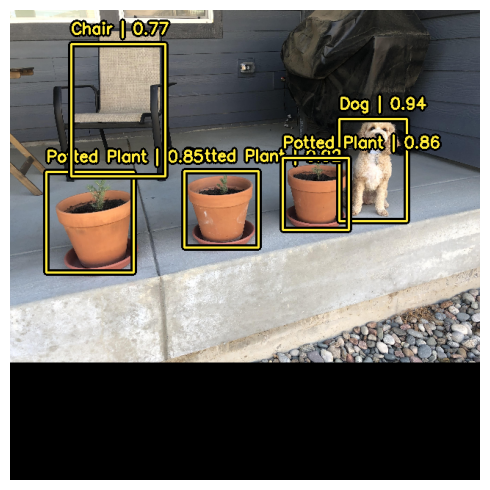

In [11]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model.prediction_decoder = prediction_decoder

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

That is much better!